In [1]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import sys
import os
import pymaster as nmt
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
from lat_cb.signal import CMB, Foreground, Noise, LATsky,Mask, BandpassInt

In [3]:
lib ='/pscratch/sd/l/lonappan/SOLAT'

# CMB simulation

In [4]:
cmb = CMB(lib,1024,0.35)

In [5]:
E,B = hp.map2alm_spin(cmb.get_cb_lensed_QU(0),2)

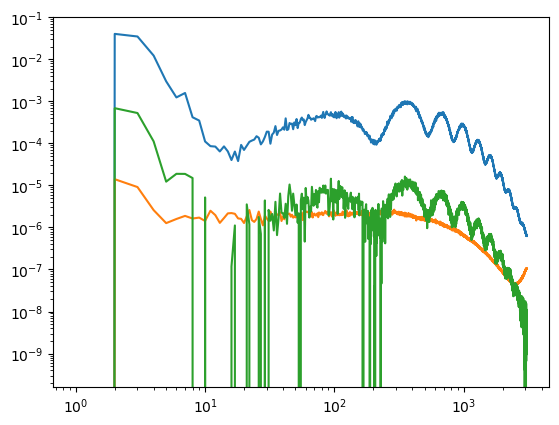

In [6]:
plt.loglog(hp.alm2cl(E),label='E')
plt.loglog(hp.alm2cl(B),label='B')
plt.loglog(hp.alm2cl(E,B),label='EB')

# Bandpass Integration

In [20]:
bp = BandpassInt()

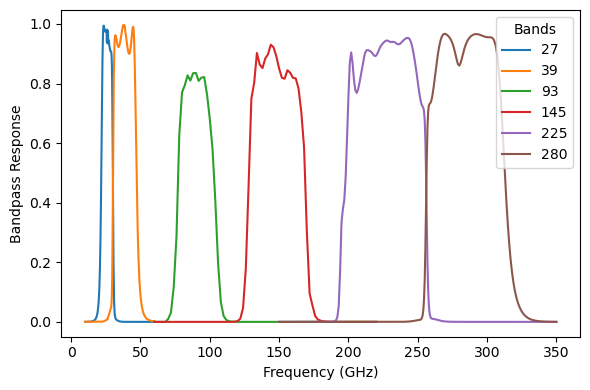

In [21]:
bp.plot_profiles()

# Foreground Simulation

In [7]:
freqs = LATsky.freqs
nlev_p = LATsky.nlevp

In [9]:
fg_wobp = Foreground(lib,512,1,1,bandpass=False)
fg_wbp = Foreground(lib,512,1,1,bandpass=True)

In [12]:
d1_wobp = fg_wobp.dustQU(145)
d1_wbp = fg_wbp.dustQU(145)

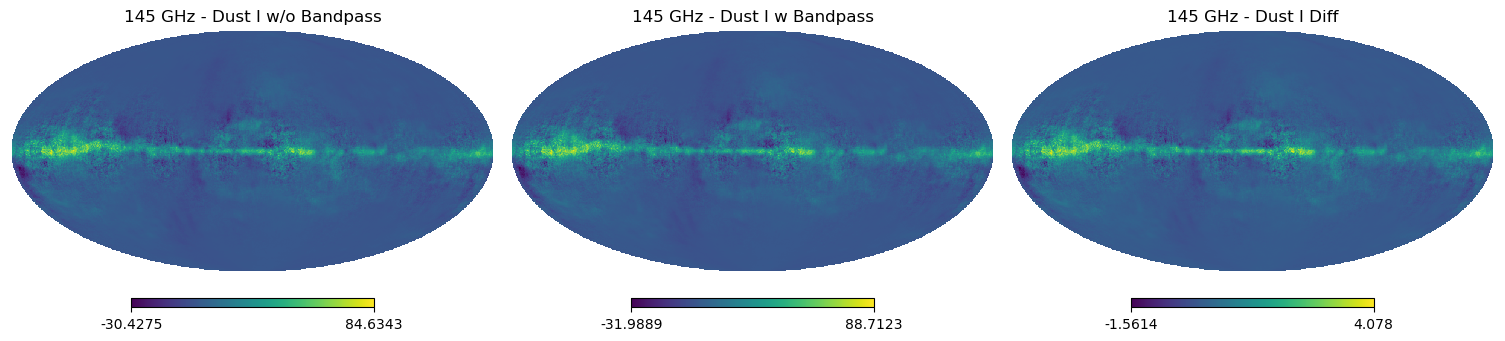

In [24]:
fig = plt.figure(figsize=(15,5))
hp.mollview(d1_wobp[0],title='145 GHz - Dust I w/o Bandpass',sub=(1,3,1))
hp.mollview(d1_wbp[0],title='145 GHz - Dust I w Bandpass',sub=(1,3,2))
hp.mollview(d1_wbp[0]-d1_wobp[0],title='145 GHz - Dust I Diff',sub=(1,3,3))

# Mask

In [168]:
nside = 1024
lmax = 3*nside-1
msk = Mask(nside)
mask = msk.get_mask(nhits=False)
hitsmap = msk.get_mask(nhits=True)

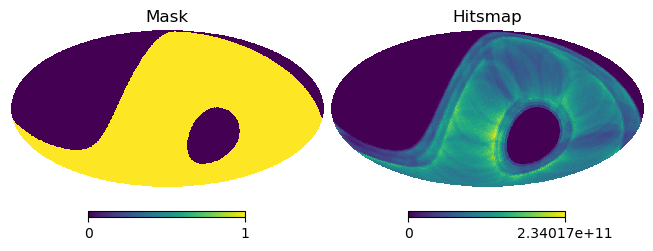

In [169]:
hp.mollview(mask,title='Mask', sub=(1,2,1))
hp.mollview(hitsmap,title='Hitsmap', sub=(1,2,2))

In [170]:
wrk = nmt.NmtWorkspace()
mask_f = nmt.NmtField(mask, [mask, mask], lmax=lmax, purify_b=False)
binInfo = nmt.NmtBin.from_lmax_linear(lmax, 10)
wrk.compute_coupling_matrix(mask_f, mask_f, binInfo)

def compute_master(f_a,f_b):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wrk.decouple_cell(cl_coupled)
    return cl_decoupled
    
b = binInfo.get_effective_ells()

# Noise Simulation - white noise

In [171]:
n = Noise(nside,atm_noise=False,nhits=True)

Noise Model: White noise
HITS map: enabled


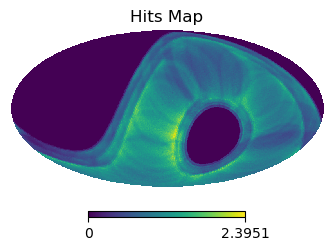

In [172]:
hp.mollview(n.hits_map,title='Hits Map',sub=(1,2,1))

In [173]:
qus = n.noiseQU()

In [174]:
q27,u27 = qus[0]
q39,u39 = qus[1]

In [175]:
f27 = nmt.NmtField(mask, [q27,u27],lmax=n.lmax, purify_b=False)
f39 = nmt.NmtField(mask, [q39,u39],lmax=n.lmax, purify_b=False)

In [176]:
ee27,_,_,bb27 = compute_master(f27,f27)
ee39,_,_,bb39 = compute_master(f39,f39)

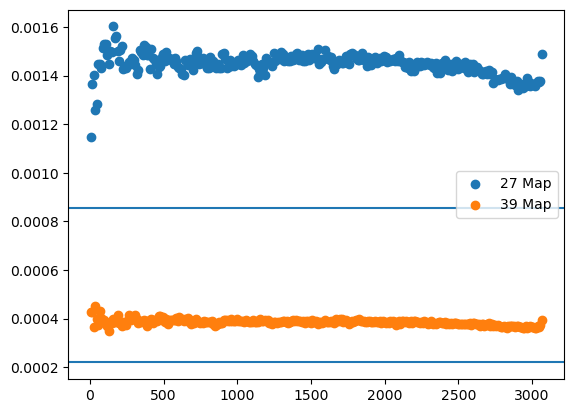

In [177]:
plt.axhline(2*np.radians(71/60)**2)
plt.scatter(b,ee27,label='27 Map')
plt.axhline(2*np.radians(36/60)**2)
plt.scatter(b,ee39,label='39 Map')
plt.legend()

# Noise Simulation - 1/f

In [178]:
n = Noise(nside,atm_noise=True,nhits=True)

Noise Model: Atmospheric noise
HITS map: enabled


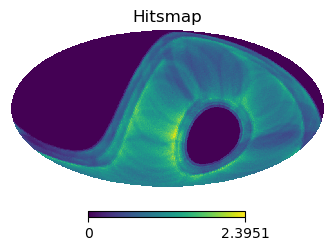

In [179]:
hp.mollview(n.hits_map,title='Hitsmap', sub=(1,2,1))

In [180]:
qus = n.noiseQUatm()

In [181]:
q27,u27 = qus[0]
q39,u39 = qus[1]

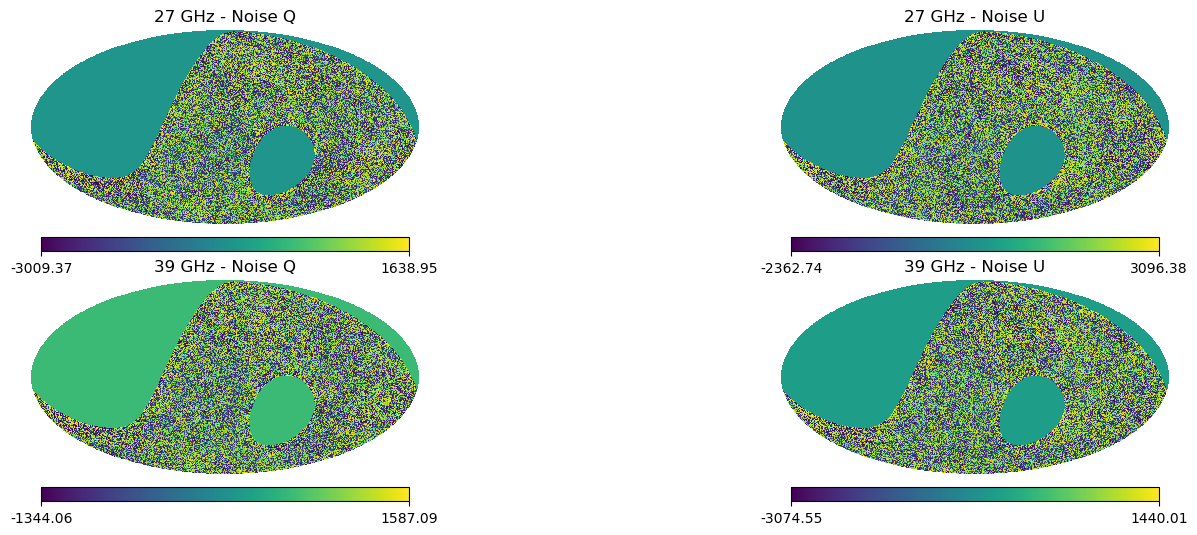

In [182]:
plt.figure(figsize=(15,10))
hp.mollview(q27,title='27 GHz - Noise Q',sub=(4,2,1),norm='hist')
hp.mollview(u27,title='27 GHz - Noise U',sub=(4,2,2),norm='hist')
hp.mollview(q39,title='39 GHz - Noise Q',sub=(4,2,3),norm='hist')
hp.mollview(u39,title='39 GHz - Noise U',sub=(4,2,4),norm='hist')

In [183]:
f27 = nmt.NmtField(mask, [q27,u27],lmax=n.lmax, purify_b=False)
f39 = nmt.NmtField(mask, [q39,u39],lmax=n.lmax, purify_b=False)

In [184]:
ee27,_,_,bb27 = compute_master(f27,f27)
ee39,_,_,bb39 = compute_master(f39,f39)
ee27_39,_,_,bb27_39 = compute_master(f27,f39)

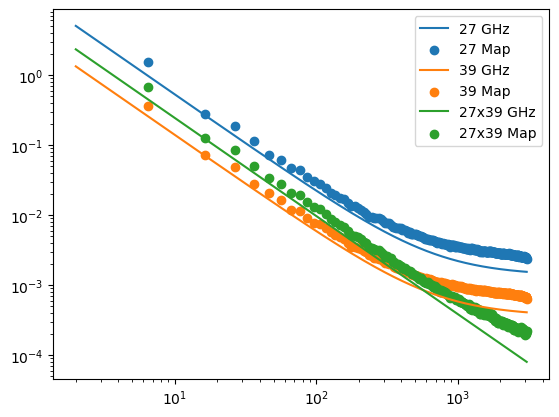

In [185]:
plt.loglog(n.Nell['ell'],n.Nell['27']*2,label='27 GHz')
plt.scatter(b,ee27,label='27 Map')
plt.loglog(n.Nell['ell'],n.Nell['39']*2,label='39 GHz')
plt.scatter(b,ee39,label='39 Map')
plt.loglog(n.Nell['ell'],n.Nell['27x39']*2,label='27x39 GHz')
plt.scatter(b,ee27_39,label='27x39 Map')
plt.legend()

In [17]:
beta = [0.1,0.1,0.8,0.8,.2,.2]

In [18]:
lat = LATsky(lib,512,0.35,1,1,beta)

In [20]:
for f in LATsky.freqs:
    q = lat.obsQU(1,f)